In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile as wav
%matplotlib inline
import modgp
import GPflow

/home/paad/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def logistic(x):
    return 1./(1+ np.exp(-x))

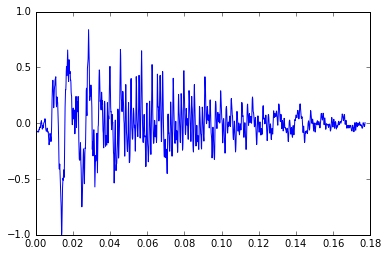

In [3]:
[sf, yaudio] = wav.read('test2_iso_sound_mono_8kHz.wav')
yaudio = (yaudio / (np.max(np.abs(yaudio))))[:,None]
#yaudio = yaudio[:,None]
sper = 1. / sf
N = np.size( yaudio)

t = np.linspace(0,(N-1)*(sper),N).reshape(-1, 1)
plt.plot(t, yaudio)




In [4]:
import matplotlib.pyplot as plt
import plotly.plotly as py
import numpy as np
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api



Fs = 8000.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t1 = np.arange(0,1,Ts) # time vector

ff = 100;   # frequency of the signal
y = np.sin(2*np.pi*ff*t)

y = yaudio[:,0]
#y =muf*logistic(mug)
t1 = t

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range



Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n/2)]

#%%

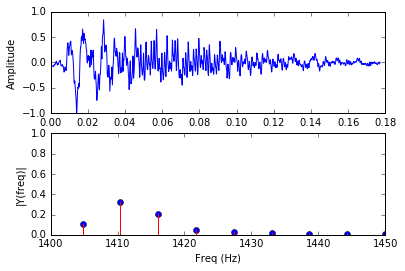

In [5]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(t1,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].stem(frq,abs(Y)/ (np.max(np.abs(Y))),'r') # plotting the spectrum
ax[1].set_xlim([1400, 1450])
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
#ax[1].set_xticks([98.00, 103.83,110.00,116.54,123.47, 130.81,138.59,146.83,2*130.81])


In [6]:
X = t

k1 = GPflow.kernels.Matern52(input_dim=1, lengthscales=10.0)
k2 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.025, variance=10.)
frec1 = 130.81
frec2 = 698.46
k_1 = GPflow.kernels.Cosine(input_dim = 1, variance=1.0,  lengthscales=1./(2*np.pi*frec2))
k_2 = GPflow.kernels.Cosine(input_dim = 1, variance=0.8,  lengthscales=1./(0.25*2*np.pi*frec2))
k_3 = GPflow.kernels.Cosine(input_dim = 1, variance=0.6,  lengthscales=1./(0.5*2*np.pi*frec2))
k_5 = GPflow.kernels.Cosine(input_dim = 1, variance=0.4,  lengthscales=1./(2*2*np.pi*frec2))
k_4 = GPflow.kernels.Cosine(input_dim = 1, variance=0.9, lengthscales=1./(3*2*np.pi*frec1))
k3 = k1*(k_1 + k_2 + k_3 + k_4 + k_5)

print 2*698.46

1396.92


In [7]:
K2 = k2.compute_K_symm(X)
K3 = k3.compute_K_symm(X)

In [8]:
noise_var = 0.001
np.random.seed(1)
f = np.random.multivariate_normal(np.zeros(X.shape[0]), K3).reshape(-1, 1)
g = np.random.multivariate_normal(np.zeros(X.shape[0]), K2).reshape(-1, 1)
mean = f * logistic(g)
y = mean + np.random.randn(*mean.shape) * np.sqrt(noise_var)

/home/paad/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning:

covariance is not positive-semidefinite.



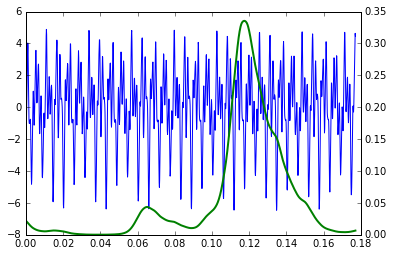

In [9]:
plt.plot(X, f, 'b')
plt.twinx()
plt.plot(X, logistic(g), 'g', lw=2)

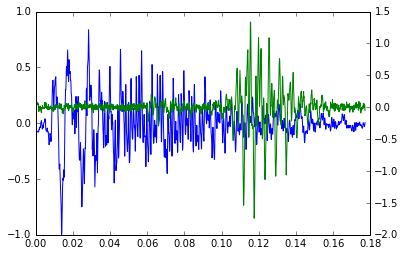

In [10]:

plt.plot(t, yaudio,'b')
plt.twinx()
plt.plot(X, y,'g')

In [11]:
yaudio =yaudio.astype(np.float64)
m = modgp.ModGP(X, yaudio, k3, k2, X[::8].copy())

In [12]:
m.kern1.fixed = True
m.kern2.fixed = True
m.likelihood.noise_var = noise_var
m.likelihood.noise_var.fixed = True

In [13]:
m.optimize(disp=1, maxiter = 5000)

      fun: 12010.622718685456
 hess_inv: <63724x63724 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.08112213, -0.        , -0.        , ...,  0.12132723,
        0.0507401 , -0.01408522])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 5242
      nit: 5001
   status: 1
  success: False
        x: array([ 1.00755169,  0.        ,  0.        , ..., -5.30647516,
       -5.25163535, -5.1888776 ])

(0.0, 0.15)

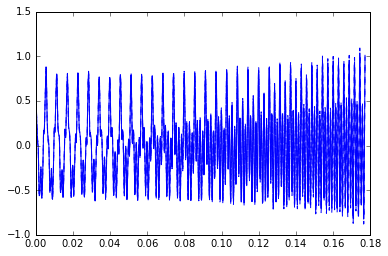

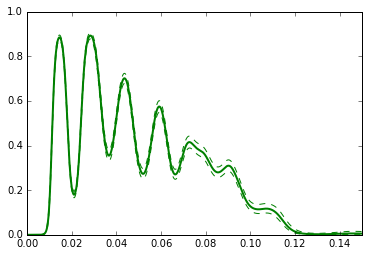

In [20]:
muf, var = m.predict_f(X)
plt.figure()
plt.plot(X, muf, 'b')
plt.plot(X, muf + 2*np.sqrt(var), 'b--')
plt.plot(X, muf - 2*np.sqrt(var), 'b--')
plt.figure()
mug, var = m.predict_g(X)
plt.plot(X, logistic(mug), 'g', lw=2)
plt.plot(X, logistic(mug + 2*np.sqrt(var)), 'g--')
plt.plot(X, logistic(mug - 2*np.sqrt(var)), 'g--')
plt.xlim([0.0,0.15])

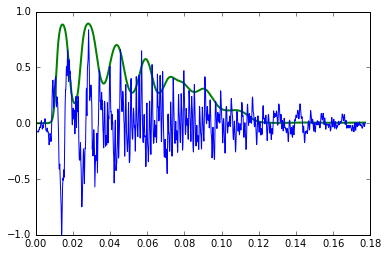

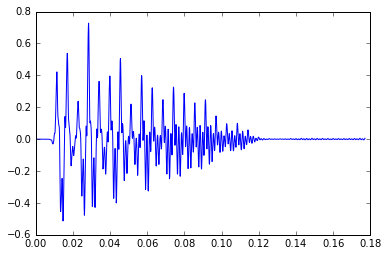

In [25]:
plt.plot(X, logistic(mug), 'g', lw=2)
#plt.plot(X, -logistic(mug), 'g', lw=1)
plt.plot(t, yaudio)
plt.figure()
plt.plot(t, muf*logistic(mug))

In [16]:
import sounddevice as sd
#sd.play(yaudio,Fs)
sd.play(muf*logistic(mug),Fs)